# 2.3 Time series prediction

## Data
We will be using daily cryptocurrency data for 8 assets from https://coinmetrics.io/data-downloads/ (for more infomation about the data structure see https://coinmetrics.io/on-data-and-certainty/).

The assets we will  be using are Bitcoin (BTC), Dash (DASH), Dogecoin (DOGE), Ethereum (ETH), Litecoin (LTC), Stellar (XLM), Monero (XMR) and Ripple (XRP)

### Loading the Data

In [42]:
# Define the path to the data directory, relative to the notebook
DATA_PATH = "data/"

"data/"

In [43]:
# Create an array of the data files
data_files = filter(x->endswith(x, ".csv"), readdir(DATA_PATH))

8-element Array{String,1}:
 "btc.csv" 
 "dash.csv"
 "doge.csv"
 "eth.csv" 
 "ltc.csv" 
 "xlm.csv" 
 "xmr.csv" 
 "xrp.csv" 

In [44]:
# Create an empty dictionary to store the data for each asset in
data = Dict{String, Any}()

Dict{String,Any} with 0 entries

In [45]:
using Pkg

Pkg.add("CSV")
Pkg.add("DataFrames")

 Resolving package versions...
  Updating `~/.julia/environments/v1.0/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.0/Manifest.toml`
 [no changes]
 Resolving package versions...
  Updating `~/.julia/environments/v1.0/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.0/Manifest.toml`
 [no changes]


In [46]:
# Load the data files as DataFrames into a dictionary with a key for each asset class
using CSV, DataFrames, Dates

expected_num_rows = 1076
columns_to_keep = ["date", "marketcap_USD_", "price_USD_", "exchangeVolume_USD_"]
rename_columns_to = ["date", "marketcap", "price", "volume"]

for file_name in data_files
    key = file_name[1:end-4]  # Drop ".csv" from the end
    df = CSV.File(DATA_PATH*file_name, normalizenames=true) |> DataFrame  # Load the CSV into a DataFrame
    
    # Keep only the date, marketcap, price and exchangevolume columns by their indices
    column_names = Dict{String, Int}(String(col) => i for (i, col) in enumerate(names(df)))
    column_indices_to_keep = [column_names[col] for col in columns_to_keep]
    df = df[column_indices_to_keep]
    @assert size(df, 2) == length(columns_to_keep)  # Check that we haven't lost any columns
                
    # Rename the columns
    names!(df, [Symbol(col) for col in rename_columns_to])
    
    # Keep all the rows from 2016-01-01 onwards
    df = df[df[:date] .>= Date("2016-01-01"), :]
    @assert size(df, 1) == expected_num_rows  # Check that we get the correct number of rows for all dataframes
    @assert sum(colwise(x -> sum(ismissing.(x)), df)) == 0  # Check that there is no missing data
    
    data[key] = df  # store the DataFrame in the dictionary
end

### A Brief Look at the Data
Let's have a look at what the data currently looks like for *BTC*.

In [47]:
data["btc"][1:8, :]  # Show rows 1 to 8 both inclusive, all columns (:)

8×4 DataFrame
│ Row │ date       │ marketcap │ price    │ volume    │
│     │ Date⍰      │ Float64⍰  │ Float64⍰ │ Float64⍰  │
├─────┼────────────┼───────────┼──────────┼───────────┤
│ 1   │ 2016-01-01 │ 6.47503e9 │ 430.72   │ 3.62789e7 │
│ 2   │ 2016-01-02 │ 6.53513e9 │ 434.62   │ 3.00966e7 │
│ 3   │ 2016-01-03 │ 6.52112e9 │ 433.58   │ 3.96338e7 │
│ 4   │ 2016-01-04 │ 6.47013e9 │ 430.06   │ 3.84775e7 │
│ 5   │ 2016-01-05 │ 6.5171e9  │ 433.07   │ 3.45226e7 │
│ 6   │ 2016-01-06 │ 6.50033e9 │ 431.86   │ 3.40425e7 │
│ 7   │ 2016-01-07 │ 6.47412e9 │ 430.01   │ 8.75622e7 │
│ 8   │ 2016-01-08 │ 6.89061e9 │ 457.54   │ 5.6993e7  │

And some elementary statistics provided by the `describe()` function.

In [48]:
describe(data["btc"])

4×8 DataFrame. Omitted printing of 3 columns
│ Row │ variable  │ mean       │ min        │ median     │ max        │
│     │ Symbol    │ Union…     │ Any        │ Union…     │ Any        │
├─────┼───────────┼────────────┼────────────┼────────────┼────────────┤
│ 1   │ date      │            │ 2016-01-01 │            │ 2018-12-11 │
│ 2   │ marketcap │ 6.81905e10 │ 5.50899e9  │ 4.13223e10 │ 3.26187e11 │
│ 3   │ price     │ 4049.44    │ 365.07     │ 2517.14    │ 19475.8    │
│ 4   │ volume    │ 2.79211e9  │ 2.8514e7   │ 1.11399e9  │ 2.38409e10 │

<hr />

## Tasks

*Note* that the following apply for all tasks:
- Write well-commented, readable code. Poor code quality will result in mark deduction.
- Feel free to organise your code across multiple notebook cells, just keep everything in the appropriate sections.
- Visualising results is encouraged.
- Be creative. Creativity will be rewarded.
- It's not all about results. Model performance will affect grade but not as much as demonstrating a good understanding of data and modelling principles.
- You should understand roughly how much effort to put into each task based on the marks allocated to it.

### Task 1: Data Analysis (20%)

You are expected to provide an analysis of the provided data. This can include visualisation, analysis of time-series data properties such as trend and seasonality, correlation between assets, etc.

In [49]:
# Your code for Task 1 goes here

### Task 2: Data Preparation (25%)

Critical to your downstream modelling task is ensuring that the data is properly prepared. Some things to think about include:
- Consider formatting the data as a time-series using a sliding window
- Data scaling or standardisation
- Using absolute versus relative values (e.g. will you use the absolute price value or a measure of how much the price has changed since the previous day? If the latter, how do you then reconstruct the absolute price on prediction?)
- Splitting into train/dev/test (evaluation will be done on the final 176 rows of the BTC dataframe (`data["btc"][901:1076, :]`). Be **very careful** to ensure there is no data leakage or data from the future being used during prediction - any such issues carry a heavy penalty)

In [50]:
# Your code for Task 2 goes here

### Task 3: Modelling (35%)

The modelling task is to predict the *BTC* **price** for the final 176 rows (`data["btc"][901:1076, :]`) of the dataframe. You should already have thought about how to organise your data properly for this in the previous task.

You are free to do any sort of modelling you wish. Having some standard baselines to compare to is a good idea. Your output should be a 1-dimensional array of length 176 called `y_pred`.

In [51]:
# Your code for Task 3 goes here

In [52]:
# Sample baseline taking the average of the previous 10 days for BTC
using Statistics
function sample_baseline(prices, num_previous_days=10)
    @assert num_previous_days > 0  # Check that the number of previous days is at least 1
    y_pred = [mean(prices[i-num_previous_days:i-1]) for i in 901:1076]
    return y_pred
end
y_pred = sample_baseline(data["btc"][:price]);

### Task 4: Evaluation (10%)

You are not expected to write anything in this section. Simply run the code provided to see how well your model does.

In [53]:
y_true = data["btc"][:price][901:1076];  # Select the ground truth data

In [54]:
function r2_score(y_true, y_pred)
    """This is a very basic implementation based on https://github.com/scikit-learn/scikit-learn/blob/55bf5d9/sklearn/metrics/regression.py#L448"""
    return 1. - sum((y_true - y_pred).^2)/(sum((y_true .- mean(y_true)).^2))
end

score = r2_score(y_true, y_pred)

0.8042005161865478

#### Visualising the results
Here we show a simple visualisation of the actual and predicted results.

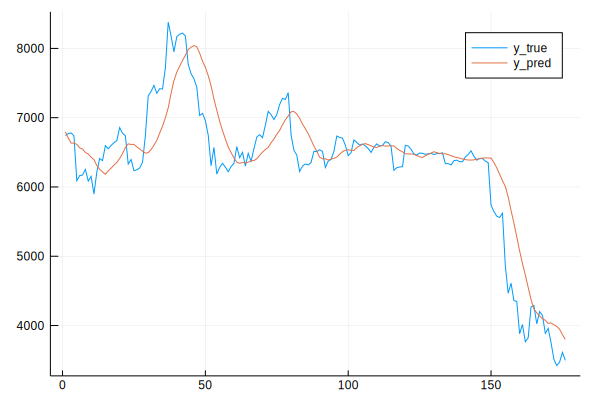

In [55]:
using Plots

plot([y_true, y_pred], labels=["y_true", "y_pred"])

### Task 5: Report (20%)

You are expected to write a short (less than 400 words in total) report on:
1. Decisions you took regarding data preprocessing and feature selection
1. Model chosen and results
1. What you learnt and ideas for improvements and future work